# Transfer Learning with MobileNetV2

Bem-vindo à tarefa desta semana, na qual você usará aprendizado de transferência em uma CNN pré-treinada para construir um classificador Alpaca/Not Alpaca!

<img src="images/alpaca.png" style="width:300px;height:220px;">

Um modelo pré-treinado é uma rede que já foi treinada em um grande conjunto de dados e salva, o que permite usá-la para personalizar seu próprio modelo de forma econômica e eficiente. O que você usará, MobileNetV2, foi projetado para fornecer desempenho rápido e computacionalmente eficiente. Ele foi pré-treinado no ImageNet, um conjunto de dados contendo mais de 14 milhões de imagens e 1.000 classes.

Ao final desta tarefa, você será capaz de:

- Criar um conjunto de dados a partir de um diretório
- Pré-processar e aumentar dados usando a API sequencial
- Adapte um modelo pré-treinado a novos dados e treine um classificador usando a API Funcional e MobileNet
- Ajuste as camadas finais de um classificador para melhorar a precisão

## Nota importante sobre envio para o AutoGrader

Antes de enviar sua tarefa para o AutoGrader, verifique se você não está fazendo o seguinte:

1. Você não adicionou nenhum comando `print` _extra_ na atribuição.
2. Você não adicionou nenhuma célula de código _extra_ na atribuição.
3. Você não alterou nenhum dos parâmetros da função.
4. Você não está usando nenhuma variável global em seus exercícios classificados. A menos que seja especificamente instruído a fazê-lo, evite-o e use as variáveis locais.
5. Você não está alterando o código de atribuição onde não é necessário, como criar variáveis _extra_.

Se você fizer qualquer um dos itens a seguir, receberá algo como "Erro do avaliador: feedback do avaliador não encontrado" (ou erro similarmente inesperado) ao enviar sua tarefa. Antes de pedir ajuda/depurar os erros em sua tarefa, verifique-os primeiro. Se esse for o caso e você não se lembrar das alterações feitas, poderá obter uma nova cópia da tarefa seguindo estas [instruções](https://www.coursera.org/learn/convolutional-neural- redes/suplemento/DS4yP/h-ow-to-refresh-your-workspace).

## Table of Content

- [1 - Packages](#1)
    - [1.1 Create the Dataset and Split it into Training and Validation Sets](#1-1)
- [2 - Preprocess and Augment Training Data](#2)
    - [Exercise 1 - data_augmenter](#ex-1)
- [3 - Using MobileNetV2 for Transfer Learning](#3)
    - [3.1 - Inside a MobileNetV2 Convolutional Building Block](#3-1)
    - [3.2 - Layer Freezing with the Functional API](#3-2)
        - [Exercise 2 - alpaca_model](#ex-2)
    - [3.3 - Fine-tuning the Model](#3-3)
        - [Exercise 3](#ex-3)

<a name='1'></a>
## 1 - Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

<a name='1-1'></a>
### 1.1 Criar o conjunto de dados e dividi-lo em conjuntos de treinamento e validação

Ao treinar e avaliar modelos de aprendizado profundo no Keras, gerar um conjunto de dados a partir de arquivos de imagem armazenados em disco é simples e rápido. Chame `image_data_set_from_directory()` para ler o diretório e criar conjuntos de dados de treinamento e validação.

Se estiver especificando uma divisão de validação, você também precisará especificar o subconjunto para cada parte. Basta definir o conjunto de treinamento como `subset='training'` e o conjunto de validação como `subset='validation'`.

Você também definirá suas sementes para corresponder umas às outras, para que seus conjuntos de treinamento e validação não se sobreponham. :)

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "datasets/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


Agora vamos dar uma olhada em algumas das imagens do conjunto de treinamento:

**Observação:** o conjunto de dados original também contém algumas imagens incorretas.

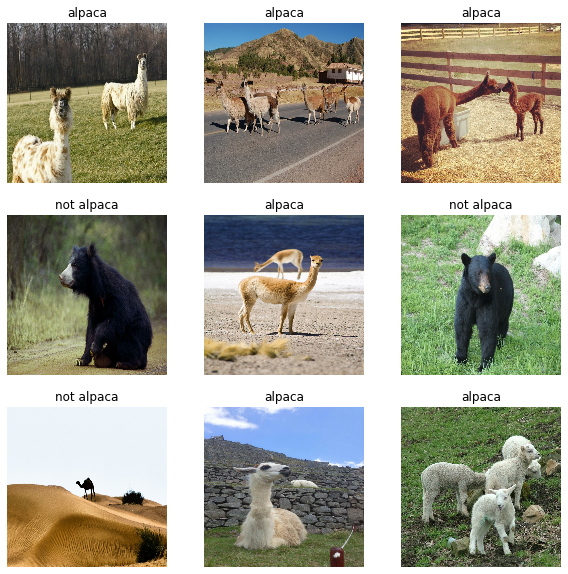

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Pré-processar e aumentar dados de treinamento

Você pode ter encontrado `dataset.prefetch` em uma atribuição anterior do TensorFlow, como uma importante etapa extra no pré-processamento de dados.

O uso de `prefetch()` evita um gargalo de memória que pode ocorrer durante a leitura do disco. Ele separa alguns dados e os mantém prontos para quando forem necessários, criando um conjunto de dados de origem a partir de seus dados de entrada, aplicando uma transformação para pré-processá-los e, em seguida, iterando sobre o conjunto de dados um elemento por vez. Como a iteração é streaming, os dados não precisam caber na memória.

Você pode definir o número de elementos para pré-busca manualmente ou pode usar `tf.data.experimental.AUTOTUNE` para escolher os parâmetros automaticamente. Autotune solicita `tf.data` para ajustar esse valor dinamicamente no tempo de execução, rastreando o tempo gasto em cada operação e alimentando esses tempos em um algoritmo de otimização. O algoritmo de otimização tenta encontrar a melhor alocação de seu orçamento de CPU em todas as operações ajustáveis.

Para aumentar a diversidade no conjunto de treinamento e ajudar seu modelo a aprender melhor os dados, é uma prática padrão aumentar as imagens transformando-as, ou seja, invertendo-as e girando-as aleatoriamente. A API sequencial da Keras oferece um método direto para esses tipos de aumentos de dados, com camadas de pré-processamento personalizáveis integradas. Essas camadas são salvas com o restante do seu modelo e podem ser reutilizadas posteriormente. Ah, tão conveniente!

Como sempre, você está convidado a ler os documentos oficiais, que você pode encontrar para aumentar os dados [aqui](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

<a name='ex-1'></a>
### Exercício 1 - data_augmenter

Implemente uma função para aumento de dados. Use um modelo de keras `Sequencial` composto por 2 camadas:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [5]:
# UNQ_C1
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential() # Cria um objeto 'Sequential' para definir a sequencia de camadas
    data_augmentation.add(tf.keras.layers.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

In [6]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')

All tests passed!


Dê uma olhada em como uma imagem do conjunto de treinamento foi aumentada com transformações simples:

De um animal fofo, a 9 variações desse animal fofo, em três linhas de código. Agora seu modelo tem muito mais com o que aprender.

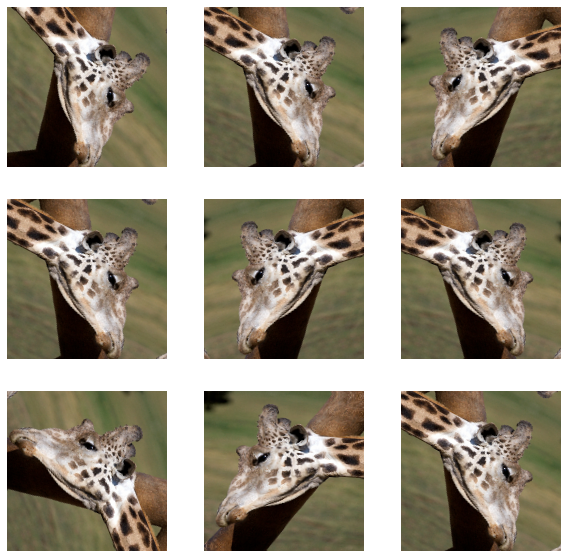

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Em seguida, você aplicará sua primeira ferramenta do aplicativo MobileNet no TensorFlow para normalizar sua entrada. Como você está usando um modelo pré-treinado que foi treinado nos valores de normalização [-1,1], é uma prática recomendada reutilizar esse padrão com tf.keras.applications.mobilenet_v2.preprocess_input.

<font color = 'blue'>

**O que você deve lembrar:**

* Ao chamar image_data_set_from_directory(), especifique os subconjuntos train/val e combine as sementes para evitar sobreposição
* Use prefetch() para evitar gargalos de memória ao ler do disco
* Dê ao seu modelo mais para aprender com aumentos de dados simples, como rotação e inversão.
* Ao usar um modelo pré-treinado, é melhor reutilizar os pesos nos quais ele foi treinado.

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='3'></a>
## 3 - Usando o MobileNetV2 para Transfer Learning

O MobileNetV2 foi treinado no ImageNet e é otimizado para rodar em aplicativos móveis e outros de baixo consumo de energia. Tem 155 camadas de profundidade (caso você sinta vontade de plotar o modelo você mesmo, prepare-se para uma longa jornada!) e muito eficiente para tarefas de detecção de objetos e segmentação de imagens, bem como tarefas de classificação como esta. A arquitetura tem três características definidoras:

* Convoluções separáveis em profundidade
* Gargalos finos de entrada e saída entre as camadas
* Conexões de atalho entre camadas de gargalo

<a name='3-1'></a>
### 3.1 - Dentro de um bloco de construção convolucional MobileNetV2

MobileNetV2 usa convoluções separáveis em profundidade como blocos de construção eficientes. As convoluções tradicionais costumam consumir muitos recursos, e as convoluções separáveis em profundidade são capazes de reduzir o número de parâmetros e operações treináveis e também acelerar as convoluções em duas etapas:

1. A primeira etapa calcula um resultado intermediário convoluindo em cada um dos canais independentemente. Esta é a convolução em profundidade.

2. Na segunda etapa, outra convolução mescla as saídas da etapa anterior em uma só. Isso obtém um único resultado de um único recurso por vez e, em seguida, é aplicado a todos os filtros na camada de saída. Esta é a convolução pontual, ou: **Forma da convolução em profundidade X Número de filtros.**

<img src="images/mobilenetv2.png" style="width:650px;height:450px;">
<caption><center> <u> <font color='purple'> <b>Figura 1</b> </u><font color='purple'> : <b>MobileNetV2 Architecture</b> <br > Este diagrama foi inspirado no original visto <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a %20significant%20melhoria,objeto%20detecção%20e%20semântica%20segmentação.">aqui</a>.</center></caption>

Cada bloco consiste em uma estrutura residual invertida com um gargalo em cada extremidade. Esses gargalos codificam as entradas e saídas intermediárias em um espaço de baixa dimensão e impedem que as não linearidades destruam informações importantes.

As conexões de atalho, que são semelhantes às das redes residuais tradicionais, têm o mesmo propósito de agilizar o treinamento e melhorar as previsões. Essas conexões ignoram as convoluções intermediárias e conectam as camadas de gargalo.

Vamos tentar treinar seu modelo base usando todas as camadas do modelo pré-treinado.

Da mesma forma que você reutilizou os valores de normalização pré-treinados nos quais o MobileNetV2 foi treinado, você também carregará os pesos pré-treinados do ImageNet especificando `weights='imagenet'`.

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14536120/14536120 [==============================] - 4s 0us/step


Imprima o resumo do modelo abaixo para ver todas as camadas do modelo, as formas de suas saídas e o número total de parâmetros, treináveis e não treináveis.

In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [11]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


Notice some of the layers in the summary like `Conv2D` and `DepthwiseConv2D` and how they follow the progression of expansion to depthwise convolution to projection. In combination with BatchNormalization and ReLU, these make up the bottleneck layers mentioned earlier.

<font color = 'blue'>

**O que você deve lembrar**:

* Os recursos exclusivos do MobileNetV2 são:
   * Convoluções separáveis em profundidade que fornecem filtragem e criação de recursos leves
   * Gargalos de entrada e saída que preservam informações importantes em cada extremidade do bloco
* Convoluções separáveis em profundidade lidam com dimensões espaciais e de profundidade (número de canais)

Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images. 

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [13]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0])>

Now decode the predictions made by the model. Earlier, when you printed the shape of the batch, it would have returned (32, 1000). The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

In [14]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 [==============================] - 0s 1us/step


[[('n02489166', 'proboscis_monkey', 0.103300065),
  ('n02102177', 'Welsh_springer_spaniel', 0.078835875)],
 [('n02125311', 'cougar', 0.16546735), ('n02389026', 'sorrel', 0.10764287)],
 [('n02437312', 'Arabian_camel', 0.29232737),
  ('n02437616', 'llama', 0.2771354)],
 [('n03944341', 'pinwheel', 0.3115499), ('n03047690', 'clog', 0.052499894)],
 [('n02454379', 'armadillo', 0.7310718), ('n01990800', 'isopod', 0.03871983)],
 [('n02437312', 'Arabian_camel', 0.25663662),
  ('n02422106', 'hartebeest', 0.12122731)],
 [('n02437616', 'llama', 0.6612555),
  ('n02090721', 'Irish_wolfhound', 0.23782845)],
 [('n02133161', 'American_black_bear', 0.82735664),
  ('n02134418', 'sloth_bear', 0.02925942)],
 [('n01518878', 'ostrich', 0.9267561),
  ('n02002724', 'black_stork', 0.0017766347)],
 [('n01518878', 'ostrich', 0.949546), ('n02018795', 'bustard', 0.0028661555)],
 [('n02437616', 'llama', 0.8699825), ('n02412080', 'ram', 0.076757714)],
 [('n02415577', 'bighorn', 0.24294604), ('n02412080', 'ram', 0.160

Uh-oh. There's a whole lot of labels here, some of them hilariously wrong, but none of them say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when you use the full model, all you get is a bunch of incorrectly classified images.

Fortunately, you can delete the top layer, which contains all the classification labels, and create a new classification layer.

<a name='3-2'></a>
### 3.2 - Layer Freezing with the Functional API

<img src="images/snowalpaca.png" style="width:400px;height:250px;">

In the next sections, you'll see how you can use a pretrained model to modify the classifier task so that it's able to recognize alpacas. You can achieve this in three steps: 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

<a name='ex-2'></a>
### Exercise 2 - alpaca_model

In [42]:
# UNQ_C2
# GRADED FUNCTION
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=None,
                                                   include_top=False,
                                                   weights=None) # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [43]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

ValueError: Output tensors of a Functional model must be the output of a TensorFlow `Layer` (thus holding past layer metadata). Found: <keras.layers.core.dense.Dense object at 0x00000151A2150BE0>

In [41]:
from test_utils import summary, comparator

alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation

comparator(summary(model2), alpaca_summary)

for layer in summary(model2):
    print(layer)

Test failed 
 Expected value 

 ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0] 

 does not match the input value: 

 ['TFOpLambda', (None, 160, 160, 3), 0]


AssertionError: Error in test

In [18]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])